In [80]:
from matplotlib import pyplot as plt 
import torch
import torchvision
import numpy as np 
import pickle as pkl
import os
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import statsmodels.api as sm

import sys 
sys.path.append('../src/')
from utils import load_config, get_corruption_scores, load_data

# Load results

In [110]:
out_dir = '../results/exp8'

res = pd.read_csv(f'{out_dir}/results.csv', sep='\t')
res.tail()

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
0,0915d36c-24be-441f-bb2d-a8c58c02ef4e,../configs/exp8.py,c9d6c23b5769fb6f03c28215112d0256,dvgs,"[0.6257311115427332, 0.6252048363203524, 0.623...","[0.6262171097397371, 0.6038367264789817, 0.561...",2550.341071
1,3a8b03ba-15b6-4469-b7b7-e384d75a87a1,../configs/exp8.py,c9d6c23b5769fb6f03c28215112d0256,dvgs,"[0.6242556959303096, 0.6258584045439265, 0.620...","[0.6240749363771928, 0.6019791894978034, 0.561...",2397.409347
2,e9bd3a35-16be-4935-8bc5-823d7185c360,../configs/exp8.py,c9d6c23b5769fb6f03c28215112d0256,dvgs,"[0.6240711502479416, 0.622862667392578, 0.6219...","[0.623940334635469, 0.6003592001054071, 0.5581...",2467.369648
3,4da0df0c-7ee4-4f68-acad-1f6437f90623,../configs/exp8.py,c9d6c23b5769fb6f03c28215112d0256,dvgs,"[0.624374128688314, 0.623016552682518, 0.62033...","[0.6243304404278154, 0.6010402976164486, 0.559...",2558.335310
4,7ea39518-d494-4590-b16b-a0f25913197b,../configs/exp8.py,c9d6c23b5769fb6f03c28215112d0256,dvgs,"[0.6240514914377624, 0.6229205771114064, 0.621...","[0.6236583869176466, 0.601002860212291, 0.5600...",2547.788497


In [111]:
res.groupby('method').count()

,uid,config,config-checksum,perf_filter_low,perf_filter_high,runtime_s
method,,,,,,
dvgs,5,5,5,5,5,5


In [112]:
vals_dict = {uid:
                {
                 'vals':np.load(f'{out_dir}/data_values/{uid}/data_values.npy', allow_pickle=True), 
                 'exog':np.load(f'{out_dir}/data_values/{uid}/exog_noise.npy', allow_pickle=True),
                 'endog':np.load(f'{out_dir}/data_values/{uid}/endog_noise.npy', allow_pickle=True)
                } 
            for uid in res.uid.values}

In [104]:
# check that all config-checksums are identical; if not, it may have changed between runs 
if res['config-checksum'].unique().shape[0] > 1: 
    print('WARNING! config checksums are not identical, config file may have changed between runs.')

# check that the same config file was used 
if res['config'].unique().shape[0] > 1: 
    print('WARNING! Different config. files were used between runs.')

In [105]:
config = load_config(res.config.values[0])

# corrupted label identification 

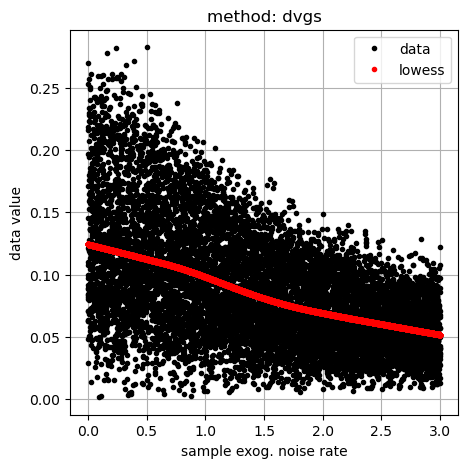

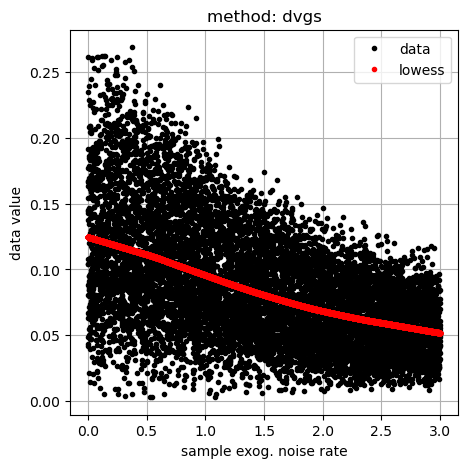

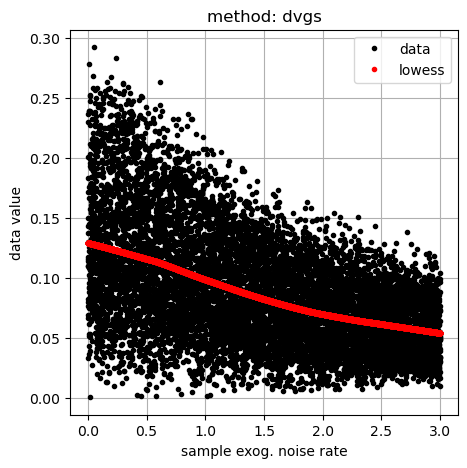

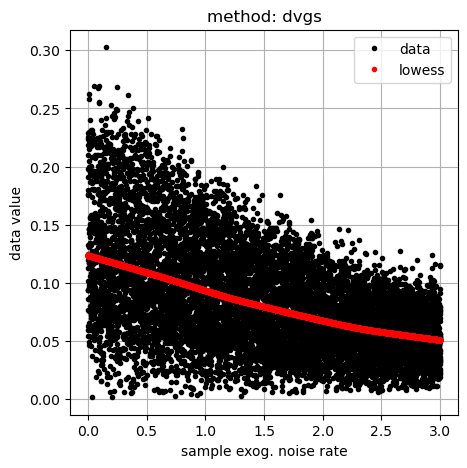

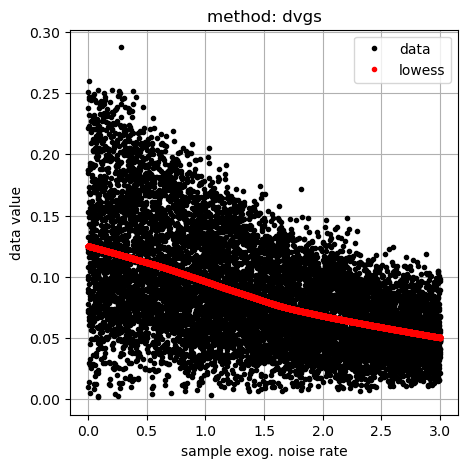

In [106]:
spearman_corr = {m:[] for m in res.method.unique()}

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    pp_corr = []
    for i,row in _temp.iterrows(): 

        exog_noise = vals_dict[row.uid]['exog']
        vals = vals_dict[row.uid]['vals']

        spearman_corr[method].append(spearmanr(exog_noise, vals)[0])

        lowess = sm.nonparametric.lowess
        lowess_fit = lowess(vals.ravel(), np.array(exog_noise).ravel(), return_sorted=False, frac=0.4)

        plt.figure(figsize=(5, 5))
        plt.plot(exog_noise, vals, "k.", label='data')
        plt.plot(exog_noise, lowess_fit, "r.", label='lowess')
        plt.xlabel('sample exog. noise rate')
        plt.ylabel('data value')
        plt.title(f'method: {method}')
        plt.grid(visible=True)
        plt.legend()
        plt.savefig(out_dir + f'/noise_vs_datavalue_{i}.png', dpi=300)
        plt.show()


In [107]:
table_latex = [[config.dataset]]
for method in ['dvgs', 'dshap', 'dvrl', 'loo', 'random']: 
    if method in spearman_corr: 
        table_latex.append( [f'{np.mean(spearman_corr[method]):.3f} $\pm$ {2*np.std(spearman_corr[method]):.3f}'] )
    else: 
        table_latex.append(['NA'])

table_latex = pd.DataFrame(table_latex).T 
table_latex.columns= ['Dataset', 'dvgs', 'dshap', 'dvrl', 'loo', 'random']

print()
#table_latex.style.to_latex()

In [108]:
table_latex

,Dataset,dvgs,dshap,dvrl,loo,random
0,lincs-hi-apc,-0.505 $\pm$ 0.018,NA,NA,NA,NA


# Filtered Data Performance

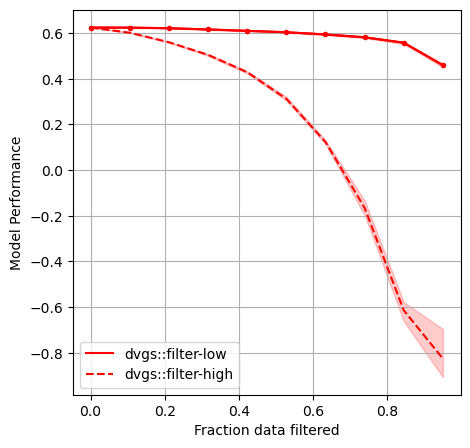

In [109]:
plt.figure(figsize=(5, 5))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    _low = [] 
    _high = [] 
    for i,row in _temp.iterrows(): 
        _low.append(row.perf_filter_low.strip('[]').split(','))
        _high.append(row.perf_filter_high.strip('[]').split(','))

    _low = np.stack(_low, axis=0).astype(float)
    _high = np.stack(_high, axis=0).astype(float)

    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, label=f'{method}::filter-low', linestyle='-')
    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, marker='.')
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_low, q=0.05, axis=0), np.quantile(a=_low, q=0.95, axis=0), color=c, alpha=.2)

    plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, linestyle='--', label=f'{method}::filter-high')
    #plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, marker='.', linestyle=None)
    plt.fill_between(config.filter_kwargs['qs'], np.quantile(a=_high, q=0.05, axis=0), np.quantile(a=_high, q=0.95, axis=0), color=c, alpha=.2)

plt.legend()
plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance')
plt.grid(visible=None)
plt.savefig(out_dir + '/label_corrupt_02.png', dpi=300)
plt.show()